# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis

### Referências Teóricas:

- Moravec & Elfes (1985) - High Resolution Maps from Wide Angle Sonar
- Thrun et al. (2005) - Probabilistic Robotics
- Slides da Aula 18: Mapeamento - Occupancy Grid

---

## 1. Imports and Initial Configuration

Import required modules and configure visualization settings.

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

# Import custom utilities
from utils.tp3_utils import (
    CoppeliaSimConnector,
    HokuyoSensorSim,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    get_noisy_laser_data,
    transform_laser_to_global,
    plot_trajectory_and_points,
    plot_laser_scan
)

# Import new simple wall-following planner (based on aula11)
from utils.wall_follower import WallFollower

# Import other utilities
from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.debug_logger import (
    log_data,
    log_function_call,
    log_transformation,
    log_robot_state,
    log_map_update,
    log_section_header
)

# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

# Configuration
DEBUG_MODE = True  # Set to False to disable debug logging

print("="*60)
print("TP3 - Occupancy Grid Mapping".center(60))
print("="*60)
print("\nAll modules imported successfully!")
print(f"Debug mode: {'ENABLED' if DEBUG_MODE else 'DISABLED'}")
print("\nExploration Strategy: Right-Hand Wall Following")
print("  - Based on class material (aula11)")
print("  - Simple reactive navigation (TP3 requirement)")
print("  - Works with static AND dynamic environments")
print("\nMake sure CoppeliaSim is running with:")
print("  - cena-tp3-estatico.ttt OR")
print("  - cena-tp3-dinamico.ttt")
print("="*60)

                TP3 - Occupancy Grid Mapping                

All modules imported successfully!
Debug mode: ENABLED

Exploration Strategy: Right-Hand Wall Following
  - Based on class material (aula11)
  - Simple reactive navigation (TP3 requirement)
  - Works with static AND dynamic environments

Make sure CoppeliaSim is running with:
  - cena-tp3-estatico.ttt OR
  - cena-tp3-dinamico.ttt


## Simulation Loop

This is the core of TP3: run a complete simulation loop to build the occupancy grid.



In [2]:
if DEBUG_MODE:
    log_section_header("SIMULATION CONFIGURATION")

# Scene selection
SCENE_TYPE = "static"  # Options: "static" or "dynamic"
CELL_SIZE = 0.1  # Cell size in meters (test with 0.01, 0.1, 0.5)

# Simulation parameters
SIMULATION_DURATION = 60.0  # seconds
DT = 0.05  # simulation time step (50ms)

# Sensor noise parameters
DISTANCE_NOISE_STD = 0.02  # 2 cm standard deviation
ANGLE_NOISE_STD = 0.005  # ~0.3 degrees standard deviation

# Map parameters
MAP_SIZE = (10, 10)  # meters (10m x 10m map)

# Navigation parameters
# ENHANCED: Reduced for closer wall navigation (validated against Kobuki specs)
V_NOMINAL = 0.70  # nominal linear velocity (m/s)
D_SAFE = 0.8  # safe distance to obstacles (m) - REDUCED from 0.8m for closer navigation

print(f"Configuration:")
print(f"  Scene: {SCENE_TYPE}")
print(f"  Cell size: {CELL_SIZE} m")
print(f"  Duration: {SIMULATION_DURATION} s")
print(f"  Map size: {MAP_SIZE} m")
print(f"  V_nominal: {V_NOMINAL} m/s")
print(f"  D_safe: {D_SAFE} m (ENHANCED: closer navigation)")

if DEBUG_MODE:
    config = {
        'scene_type': SCENE_TYPE,
        'cell_size': CELL_SIZE,
        'duration': SIMULATION_DURATION,
        'dt': DT,
        'map_size': MAP_SIZE,
        'v_nominal': V_NOMINAL,
        'd_safe': D_SAFE,
        'noise': {
            'distance_std': DISTANCE_NOISE_STD,
            'angle_std': ANGLE_NOISE_STD
        }
    }
    log_data("Simulation Configuration", config, DEBUG_MODE)


                  SIMULATION CONFIGURATION                  

Configuration:
  Scene: static
  Cell size: 0.1 m
  Duration: 60.0 s
  Map size: (10, 10) m
  V_nominal: 0.7 m/s
  D_safe: 0.8 m (ENHANCED: closer navigation)

[DEBUG] Simulation Configuration
------------------------------------------------------------
  Type: dict
  Keys: ['scene_type', 'cell_size', 'duration', 'dt', 'map_size', 'v_nominal', 'd_safe', 'noise']
    scene_type: static
    cell_size: 0.1
    duration: 60.0
    dt: 0.05
    map_size: tuple
    v_nominal: 0.7
    d_safe: 0.8
    noise: dict
------------------------------------------------------------


In [3]:
if DEBUG_MODE:
    log_section_header("INITIALIZE COMPONENTS")

# Create fresh controller and mapper
controller = KobukiController(robot_name='kobuki')
mapper = OccupancyGridMapper(map_size=MAP_SIZE, cell_size=CELL_SIZE)

# EXPLORATION STRATEGY: RIGHT-HAND WALL FOLLOWING
# ================================================
# Simple reactive navigation based on class material (aula11-bug-zmq)
#
# Why this strategy is appropriate for TP3:
# 1. SIMPLE: Only ~150 lines of code with clear logic
# 2. REACTIVE: Responds directly to sensor data (no global planning)
# 3. EXPLORATION: Systematically covers environment by following walls
# 4. DYNAMIC COMPATIBLE: Works with moving obstacles (purely sensor-driven)
# 5. CLASS-BASED: Implements wall-following from aula11
#
# How it works:
# - Divides laser into 3 sectors (right, front, left)
# - Applies simple rules:
#   * Obstacle ahead -> Turn left (safety)
#   * Wall on right -> Follow it (maintain distance)
#   * No wall on right -> Search for wall (turn right)
#   * Open space -> Move forward
#
# This is MUCH simpler than potential fields or goal-based planners,
# and meets TP3 requirement for "simple strategy based on class algorithms"

planner = WallFollower(
    v_nominal=V_NOMINAL,
    w_max=np.deg2rad(45),  # 45 degrees/second max turn rate
    d_safe=D_SAFE,          # Safety distance (same as before)
    d_follow=0.6            # Target distance to maintain from right wall
)

# Connect and initialize
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene")

# Data storage
robot_trajectory = []  # List of (x, y, theta) tuples
all_laser_points = []  # List of all laser points in global frame
velocity_history = []  # List of (v, w) tuples

print("\nAll components initialized successfully!")
print("\nStarting simulation in 1 second...")
time.sleep(1)


                   INITIALIZE COMPONENTS                    

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
Occupancy Grid initialized (OPTIMIZED - based on occrGrid.py + aula18):
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Grid coverage: [0.0, 10.0] x [0.0, 10.0] m
  Origin: [0. 0.] (FIXED: starts at 0,0 per aula18 theory)
  Log-odds: l_occ=2.197, l_free=-2.197, l_prior=0.0
  Update strength: ~3.5x stronger than roadmap.py (faster confidence buildup)
  Hit radius: 0.1m (marks cells within radius as occupied)
  Algorithm: Bayesian update with distance-based weighting
Wall Follower Initialized
  Strategy: Right-hand wall following (reactive)
  Nominal velocity: 0.7 m/s
  Max angular velocity: 45.0 deg/s
  Safety distance: 0.8 m
  Wall-following distance: 0.6 m
  Critical distance: 0.2 m (emergency)
  Very close distance: 0.25 m (back up)
  Debug mode: DISABLED

Safety Parameters 

## 6.5. Real-time Visualization Setup

Initialize the real-time plotting for debugging navigation and mapping.

This will show:
1. **Laser Scan (Top-Left)**: Raw laser data in robot's local frame
2. **Global View (Top-Right)**: Robot trajectory + laser points in world frame  
3. **Occupancy Grid (Bottom)**: Real-time map updates

Based on TP1_ex5-6.ipynb approach with interactive matplotlib updates.

## 6.6. Helper Function for Sector Visualization

Create a helper function to visualize laser sectors (right, front, left) on the polar plot.
This will help debug the wall-following algorithm by showing which sectors the robot is using for navigation.

In [4]:
def add_sector_visualization(ax_laser, laser_data, d_safe, d_follow):
    """
    Add visual indicators for laser sectors on polar plot.

    This helps debug the wall-following by showing:
    - RIGHT sector (-90° to -30°): Used to detect and follow wall
    - FRONT sector (-30° to +30°): Used to detect obstacles ahead
    - LEFT sector (+30° to +90°): Used for general awareness

    Also draws:
    - Safety distance circle (d_safe): Red dashed line
    - Follow distance circle (d_follow): Green dashed line

    Args:
        ax_laser: Matplotlib polar axis for laser plot
        laser_data: Nx2 array with [angle, distance]
        d_safe: Safety distance threshold (m)
        d_follow: Wall-following distance threshold (m)
    """
    # Draw sector boundaries
    sector_angles = [np.deg2rad(-90), np.deg2rad(-30), np.deg2rad(30), np.deg2rad(90)]

    for angle in sector_angles:
        ax_laser.plot([angle, angle], [0, 5.0], 'g--', alpha=0.3, linewidth=1)

    # Draw distance thresholds as circles
    theta_circle = np.linspace(np.deg2rad(-90), np.deg2rad(90), 100)

    # Safety distance (red)
    ax_laser.plot(theta_circle, np.ones_like(theta_circle) * d_safe,
                  'r--', alpha=0.5, linewidth=1.5, label=f'd_safe={d_safe}m')

    # Follow distance (green)
    ax_laser.plot(theta_circle, np.ones_like(theta_circle) * d_follow,
                  'g--', alpha=0.5, linewidth=1.5, label=f'd_follow={d_follow}m')

    # Add sector labels
    ax_laser.text(np.deg2rad(-60), 4.5, 'RIGHT', fontsize=8, ha='center', color='blue', weight='bold')
    ax_laser.text(np.deg2rad(0), 4.5, 'FRONT', fontsize=8, ha='center', color='red', weight='bold')
    ax_laser.text(np.deg2rad(60), 4.5, 'LEFT', fontsize=8, ha='center', color='green', weight='bold')

    # Add legend
    ax_laser.legend(loc='upper left', fontsize=7, bbox_to_anchor=(0, 1.15))

print("Sector visualization helper function defined!")
print("  - Shows RIGHT, FRONT, LEFT sectors")
print("  - Displays safety and follow distance thresholds")
print("  - Helps debug wall-following behavior")

Sector visualization helper function defined!
  - Shows RIGHT, FRONT, LEFT sectors
  - Displays safety and follow distance thresholds
  - Helps debug wall-following behavior


In [5]:
# Use inline backend for compatibility
%matplotlib inline
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend for saving figures

# We'll create periodic snapshots instead of real-time updates
# This is more reliable and works in all environments

print("="*60)
print("Visualization Mode: Periodic Snapshots")
print("="*60)
print("  - Figures will be saved every 10 seconds during simulation")
print("  - Final comprehensive plots will be shown at the end")
print("  - This approach is more compatible and reliable")
print("="*60)

Visualization Mode: Periodic Snapshots
  - Figures will be saved every 10 seconds during simulation
  - Final comprehensive plots will be shown at the end
  - This approach is more compatible and reliable


In [6]:
if DEBUG_MODE:
    log_section_header("MAIN SIMULATION LOOP")

# Create directory for snapshots
import os
os.makedirs('snapshots', exist_ok=True)

# === MAX-RANGE FILTERING CONSTANT ===
# Following ROS LaserScan convention: readings at max_range indicate "no detection"
# and should NOT be treated as obstacles for occupancy grid mapping
# Threshold: 99% of sensor max range (5.0m)
MAX_VALID_RANGE = 4.95  # meters

try:
    # Start simulation
    controller.sim.startSimulation()
    time.sleep(1)
    print("Simulation started!")

    start_time = time.time()
    iteration = 0
    last_snapshot_time = 0

    while (time.time() - start_time) < SIMULATION_DURATION:
        # 1. Get robot pose
        robot_pose = controller.get_pose()
        x, y, theta = controller.get_pose_2d()
        robot_trajectory.append((x, y, theta))

        # 2. Get laser data (RAW, without noise)
        laser_data = controller.get_laser_data()
        if laser_data is None:
            print("Warning: No laser data, skipping iteration")
            time.sleep(DT)
            continue

        # CRITICAL FIX #2: Filter BEFORE Adding Noise (Based on aula18 Slide 26)
        # ========================================================================
        # Theory (Slide 26 inverse_sensor_model line 5):
        #   "if z_t^k < z_max..." - Check validity FIRST
        #
        # PROBLEM WITH OLD APPROACH (noise before filtering):
        # - Noise could push valid 4.9m reading to 5.1m → filtered out (loss)
        # - Noise could push invalid 5.0m reading to 4.8m → kept as valid (error)
        # - This created random noise in the map
        #
        # CORRECT APPROACH (filter then noise):
        # - Filter out max-range readings (5.0m = no detection)
        # - THEN add noise to valid readings only
        # - Prevents invalid readings from polluting the map
        #
        # Reference: aula18-mapeamento-occupancy-grid.md Slide 26

        # 3. === FILTER MAX-RANGE READINGS FIRST ===
        valid_mask = laser_data[:, 1] < MAX_VALID_RANGE
        laser_data_filtered = laser_data[valid_mask].copy()

        # 4. === ADD NOISE AFTER FILTERING ===
        # Now we only add noise to readings that detected actual obstacles
        # Following robotics literature for Hokuyo sensors:
        # - Angle noise: ~0.005 rad (0.29°) - typical laser scanner angular uncertainty
        # - Distance noise: ~0.02 m (2cm) - typical Hokuyo range uncertainty
        laser_data_filtered[:, 0] += np.random.normal(0, ANGLE_NOISE_STD, len(laser_data_filtered))
        laser_data_filtered[:, 1] += np.random.normal(0, DISTANCE_NOISE_STD, len(laser_data_filtered))

        # Ensure distances stay within valid range after noise
        laser_data_filtered[:, 1] = np.clip(laser_data_filtered[:, 1], 0.01, MAX_VALID_RANGE - 0.01)

        # 5. Transform to global frame (ONLY VALID DETECTIONS)
        # CRITICAL FIX: Use laser-to-robot transform from controller if available
        from utils.tp3_utils import transform_laser_to_global
        laser_transform = getattr(controller, 'laser_to_robot_transform', None)
        laser_points_global = transform_laser_to_global(
            robot_pose, laser_data_filtered, laser_to_robot_transform=laser_transform
        )
        all_laser_points.extend(laser_points_global.tolist())

        # 6. Update occupancy grid (ONLY VALID DETECTIONS)
        mapper.update_map(robot_pose, laser_points_global)

        # 7. Plan next velocities using wall-following (USE ORIGINAL DATA with max-range)
        # Wall follower needs ALL readings to detect "clear space" (max-range = no obstacle)
        v, w = planner.plan_step(laser_data)
        velocity_history.append((v, w))

        # 8. Send velocities to robot
        controller.set_velocity(v, w)

        # 9. Step simulation
        controller.sim.step()

        # 10. CREATE PERIODIC SNAPSHOTS (every 10 seconds)
        elapsed = time.time() - start_time
        if elapsed - last_snapshot_time >= 10:
            print(f"\n[Snapshot at {elapsed:.1f}s] Saving visualization...")

            # Create 3-panel visualization
            fig_snap, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Panel 1: Laser scan (polar plot) - SHOW ONLY VALID DETECTIONS
            ax_laser = plt.subplot(131, projection='polar')
            ax_laser.scatter(laser_data_filtered[:, 0], laser_data_filtered[:, 1],
                           c='blue', s=2, alpha=0.6)
            ax_laser.set_ylim(0, 5.0)
            ax_laser.set_title(f'Laser Scan (Valid Only) @ {elapsed:.1f}s', fontsize=10)
            ax_laser.grid(True, alpha=0.3)

            # Panel 2: Global view
            ax_global = axes[1]
            traj = np.array(robot_trajectory)
            ax_global.plot(traj[:, 0], traj[:, 1], 'r-', linewidth=2, alpha=0.8, label='Trajectory')
            ax_global.scatter(x, y, c='green', s=100, marker='o', edgecolor='black',
                            linewidth=2, zorder=5, label='Current Position')
            # Plot FILTERED laser points in global frame
            laser_global_array = np.array(laser_points_global)
            ax_global.scatter(laser_global_array[:, 0], laser_global_array[:, 1],
                            c='blue', s=1, alpha=0.3, label='Laser Points (Valid)')
            ax_global.set_xlim(0, 10)
            ax_global.set_ylim(0, 10)
            ax_global.set_xlabel('X (m)')
            ax_global.set_ylabel('Y (m)')
            ax_global.set_title(f'Global View @ {elapsed:.1f}s', fontsize=10)
            ax_global.grid(True, alpha=0.3)
            ax_global.legend(loc='upper right', fontsize=8)
            ax_global.set_aspect('equal')

            # Panel 3: Occupancy grid
            ax_grid = axes[2]
            prob_map = mapper.get_probability_map()
            im = ax_grid.imshow(prob_map, cmap='gray_r', origin='lower',
                              extent=[mapper.x_min, mapper.x_max, mapper.y_min, mapper.y_max],
                              vmin=0, vmax=1)
            ax_grid.plot(traj[:, 0], traj[:, 1], 'r-', linewidth=1.5, alpha=0.8)
            ax_grid.scatter(x, y, c='green', s=50, marker='o', edgecolor='black', zorder=5)
            ax_grid.set_xlabel('X (m)')
            ax_grid.set_ylabel('Y (m)')
            ax_grid.set_title(f'Occupancy Grid @ {elapsed:.1f}s', fontsize=10)
            ax_grid.grid(True, alpha=0.3)
            ax_grid.set_aspect('equal')
            plt.colorbar(im, ax=ax_grid, label='P(occupied)', fraction=0.046, pad=0.04)

            # Save snapshot
            filename = f'snapshots/snapshot_{int(elapsed):03d}s.png'
            plt.tight_layout()
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            plt.close(fig_snap)
            print(f"Saved: {filename}")

            last_snapshot_time = elapsed

        # Progress indicator
        iteration += 1
        if iteration % 100 == 0:
            elapsed = time.time() - start_time
            print(f"[{elapsed:.1f}s] Iteration {iteration}, Valid points: {len(laser_data_filtered)}/{len(laser_data)}")

except Exception as e:
    print(f"Error in simulation: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Always stop the robot and simulation
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
    time.sleep(1)
    print("Simulation stopped!")

# Print final statistics
elapsed = time.time() - start_time
print("\n" + "="*70)
print("SIMULATION COMPLETE")
print("="*70)
final_stats = {
    "Duration": f"{elapsed:.2f}s",
    "Iterations": iteration,
    "Trajectory Points": len(robot_trajectory),
    "Laser Points Collected": len(all_laser_points),
    "Grid Size": f"{mapper.grid_map.shape}",
    "Cell Size": f"{CELL_SIZE}m"
}
for key, value in final_stats.items():
    print(f"{key:.<30} {value}")
print("="*70)


                    MAIN SIMULATION LOOP                    

Simulation started!
Simulation started!

[WallFollower] Laser data verification:
  Shape: (684, 2)
  First 3 readings: [[-2.08827114  0.23404652]
 [-2.08214718  0.2342474 ]
 [-2.07602322  0.23356149]]
  Angle range: [-119.6°, 120.0°]
  Distance range: [0.233m, 5.000m]
  Expected: 684 beams covering -90° to +90°


[WallFollower] Laser data verification:
  Shape: (684, 2)
  First 3 readings: [[-2.08827114  0.23404652]
 [-2.08214718  0.2342474 ]
 [-2.07602322  0.23356149]]
  Angle range: [-119.6°, 120.0°]
  Distance range: [0.233m, 5.000m]
  Expected: 684 beams covering -90° to +90°

[WallFollower] Iter    5 | State: follow_wall     | d_min=0.30m, d_right=0.30m, d_front=0.93m | v=0.70, w=+17.2°/s
[WallFollower] Iter    5 | State: follow_wall     | d_min=0.30m, d_right=0.30m, d_front=0.93m | v=0.70, w=+17.2°/s
[WallFollower] Iter   10 | State: forward         | d_min=1.43m, d_right=1.43m, d_front=1.81m | v=0.70, w=+0.0°/s
[Wall

## plot_incremental_map

Plotting 17,082 / 138,702 points (12.3%)


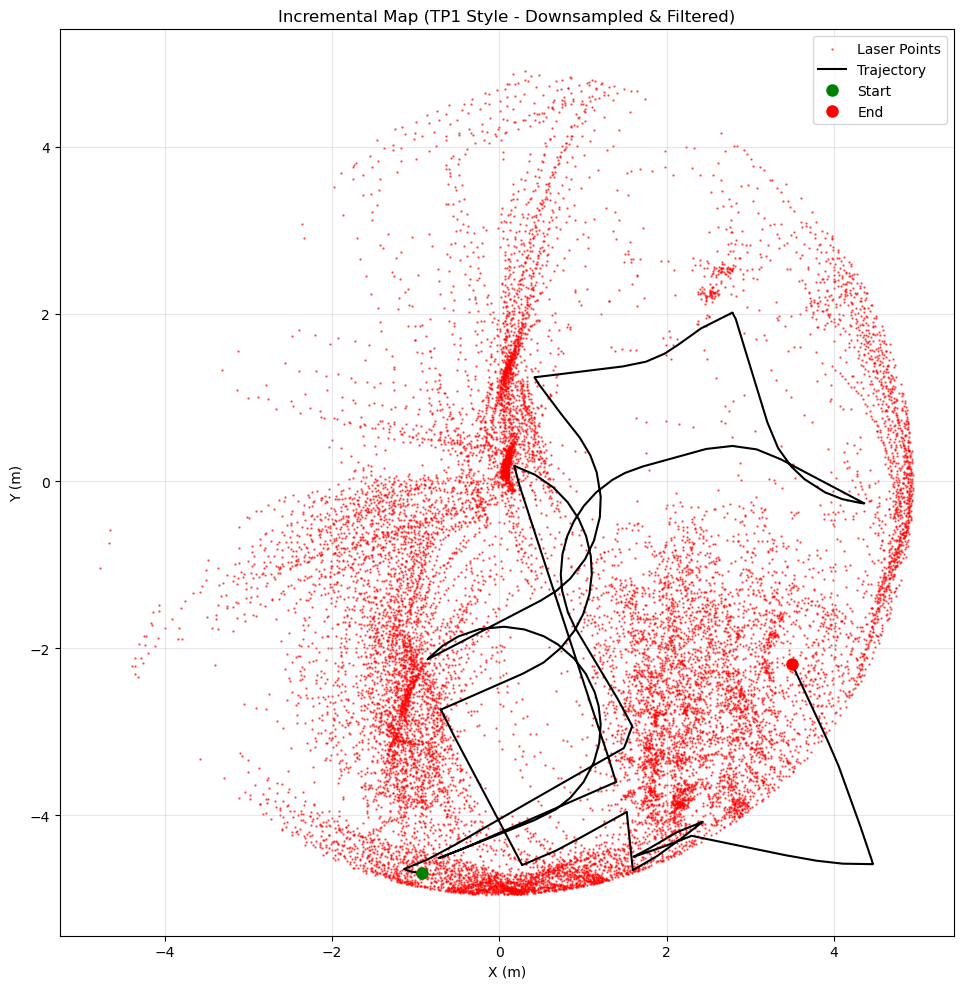

In [7]:
# Switch back to inline backend for display
%matplotlib inline

from utils.tp3_utils import plot_incremental_map
plot_incremental_map(robot_trajectory, all_laser_points, sample_points=5)

## 11. Results and Analysis

### 11.1 Final Map Statistics

In [8]:
# Get final map statistics
final_stats = mapper.get_statistics()

print("="*60)
print("FINAL MAP STATISTICS")
print("="*60)
print(f"Total cells: {final_stats['total_cells']}")
print(f"Occupied cells: {final_stats['occupied_cells']} ({final_stats['occupied_percent']:.2f}%)")
print(f"Free cells: {final_stats['free_cells']} ({final_stats['free_percent']:.2f}%)")
print(f"Unknown cells: {final_stats['unknown_cells']} ({final_stats['unknown_percent']:.2f}%)")
print("="*60)

FINAL MAP STATISTICS
Total cells: 10000
Occupied cells: 555 (5.55%)
Free cells: 2763 (27.63%)
Unknown cells: 6682 (66.82%)


### 11.2 Visualize Final Occupancy Grid

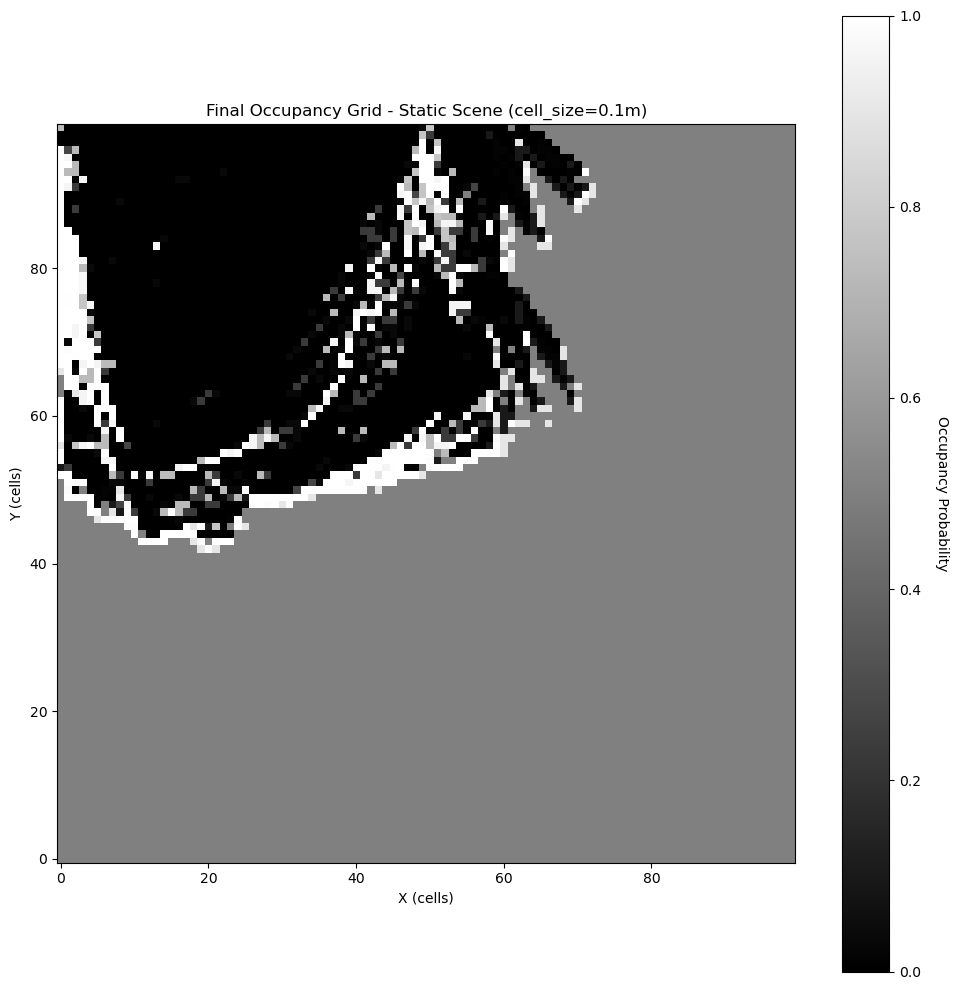

[OK] Map saved to: occupancy_grid_static_cell0.1.png
Map saved to: occupancy_grid_static_cell0.1.png


In [9]:
# Visualize final occupancy grid
mapper.visualize_map(title=f"Final Occupancy Grid - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)")

# Save map image
filename = f"occupancy_grid_{SCENE_TYPE}_cell{CELL_SIZE}.png"
mapper.save_map_image(filename)
print(f"Map saved to: {filename}")

### 11.3 Incremental Plot (Trajectory + Laser Points)

This plot shows:
- **Robot trajectory** (red line with markers)
- **Laser points** (blue dots) - **ONLY VALID DETECTIONS** (distance < 4.95m)

**Important:** Max-range readings (5.0m) are filtered out because they indicate "no obstacle detected" (following ROS LaserScan convention). This prevents false "noise cloud" at sensor max range.

This matches Figure (b) from the TP3 requirements.

Incremental plot (all points) saved to: incremental_plot_all_static_cell0.1.png


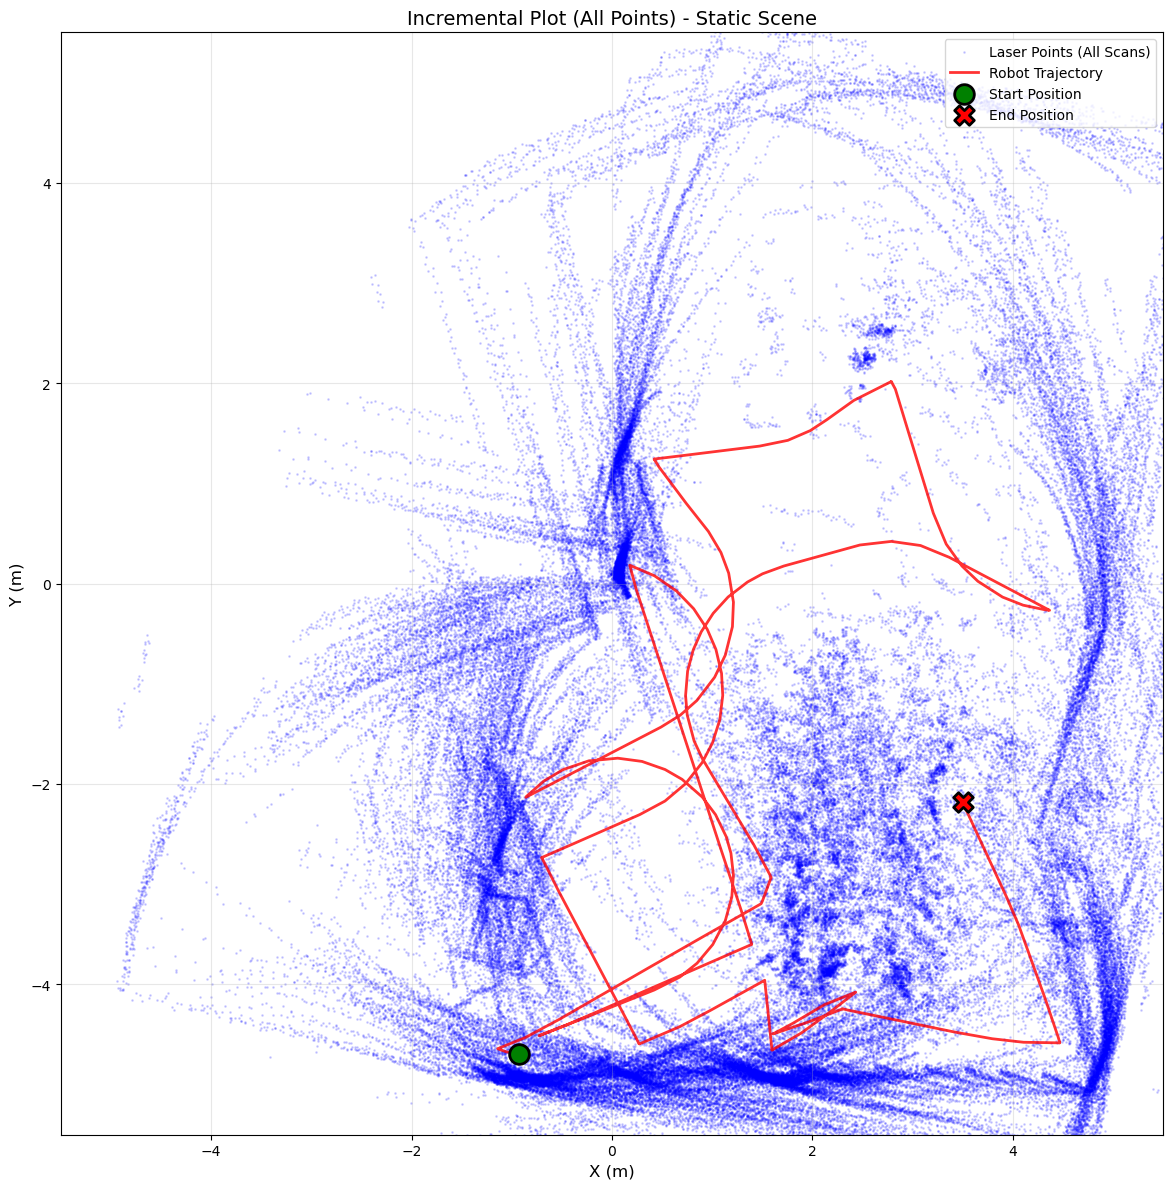


Downsampling: 138702 → 27741 points (20%)
Incremental plot (downsampled) saved to: incremental_plot_clean_static_cell0.1.png
Incremental plot (downsampled) saved to: incremental_plot_clean_static_cell0.1.png


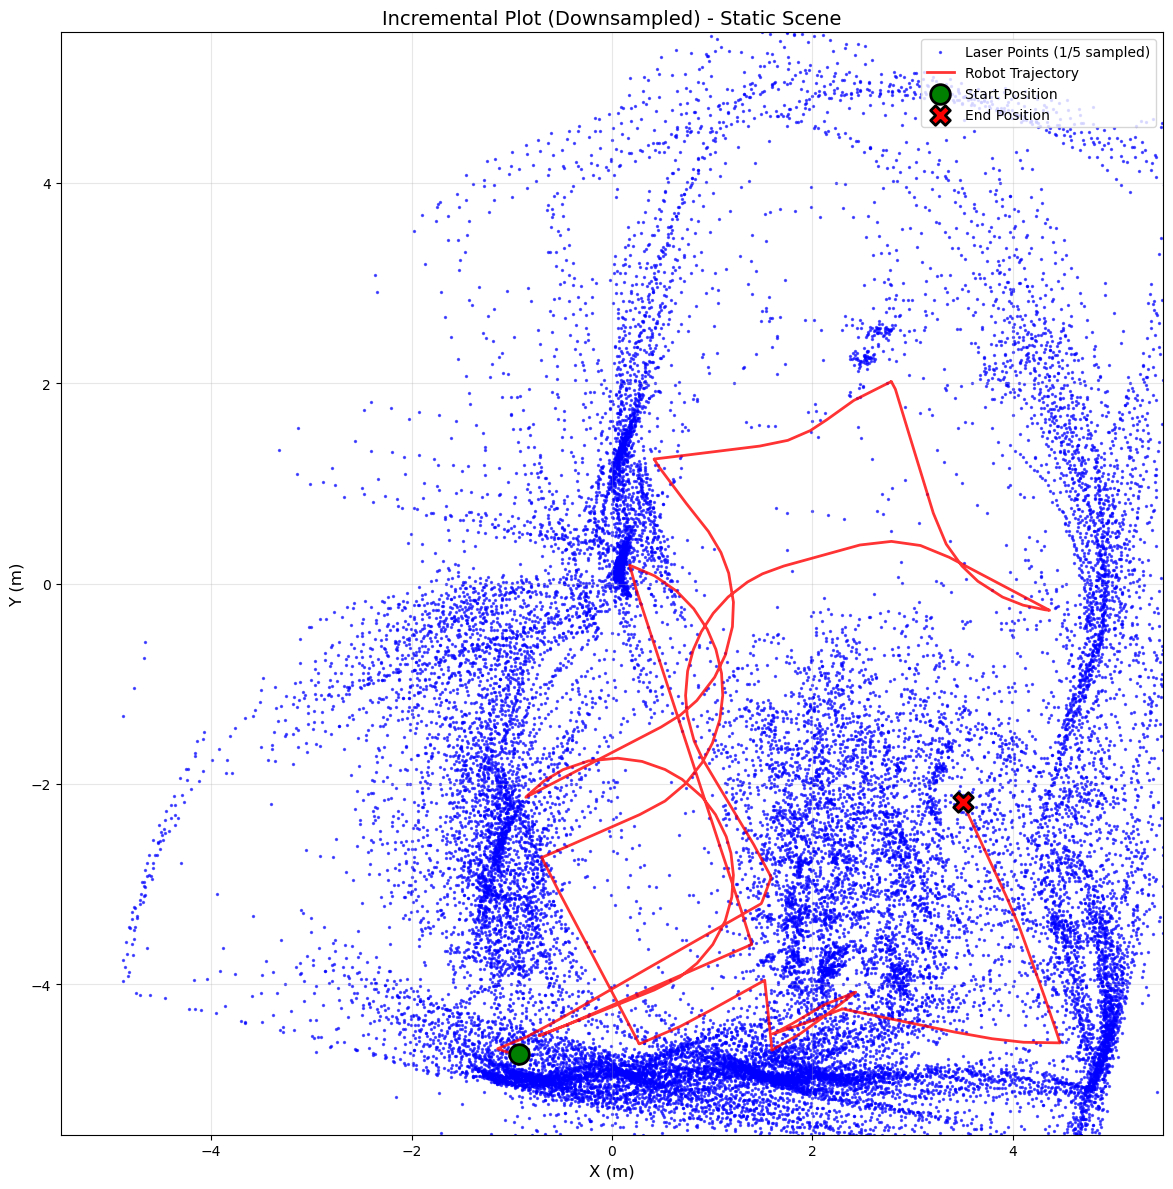


Note: Both plots show the same data with correct transformations.
The 'downsampled' version provides cleaner visualization (similar to TP1 Exercise 6).


In [10]:
# Convert trajectory and laser points to arrays
trajectory_array = np.array(robot_trajectory)
laser_points_array = np.array(all_laser_points)

# NOTE: all_laser_points already contains ONLY valid detections (filtered in main loop)
# Max-range readings (>= 4.95m) were excluded to prevent "noise cloud" at sensor limit

# === OPTION 1: Plot ALL accumulated points (shows full data, may appear "thick") ===
# This shows EVERY laser point collected during 60 seconds of navigation
# Walls appear thicker due to thousands of overlapping measurements

fig, ax = plt.subplots(figsize=(12, 12))

# Plot all laser points (already filtered for valid detections)
ax.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
          c='blue', s=1, alpha=0.15, label='Laser Points (All Scans)')

# Plot robot trajectory
ax.plot(trajectory_array[:, 0], trajectory_array[:, 1],
        'r-', linewidth=2, alpha=0.8, label='Robot Trajectory')

# Mark start and end positions
ax.scatter(trajectory_array[0, 0], trajectory_array[0, 1],
          c='green', s=200, marker='o', edgecolor='black', linewidth=2,
          zorder=5, label='Start Position')
ax.scatter(trajectory_array[-1, 0], trajectory_array[-1, 1],
          c='red', s=200, marker='X', edgecolor='black', linewidth=2,
          zorder=5, label='End Position')

# Configure plot
ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_title(f'Incremental Plot (All Points) - {SCENE_TYPE.capitalize()} Scene', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
ax.set_aspect('equal')
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5.5, 5.5)

# Save incremental plot
filename = f"incremental_plot_all_{SCENE_TYPE}_cell{CELL_SIZE}.png"
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Incremental plot (all points) saved to: {filename}")
plt.show()


# === OPTION 2: Plot DOWNSAMPLED points (cleaner, matches TP1 style) ===
# This creates cleaner visualization by reducing point density
# Similar to TP1 Exercise 6 appearance

fig2, ax2 = plt.subplots(figsize=(12, 12))

# Downsample laser points for cleaner visualization
# Use every 5th point to reduce density while maintaining wall structure
downsample_factor = 5
laser_downsampled = laser_points_array[::downsample_factor]

print(f"\nDownsampling: {len(laser_points_array)} → {len(laser_downsampled)} points ({100/downsample_factor:.0f}%)")

# Plot downsampled laser points (cleaner appearance)
ax2.scatter(laser_downsampled[:, 0], laser_downsampled[:, 1],
          c='blue', s=2, alpha=0.6, label=f'Laser Points (1/{downsample_factor} sampled)')

# Plot robot trajectory
ax2.plot(trajectory_array[:, 0], trajectory_array[:, 1],
        'r-', linewidth=2, alpha=0.8, label='Robot Trajectory')

# Mark start and end positions
ax2.scatter(trajectory_array[0, 0], trajectory_array[0, 1],
          c='green', s=200, marker='o', edgecolor='black', linewidth=2,
          zorder=5, label='Start Position')
ax2.scatter(trajectory_array[-1, 0], trajectory_array[-1, 1],
          c='red', s=200, marker='X', edgecolor='black', linewidth=2,
          zorder=5, label='End Position')

# Configure plot
ax2.set_xlabel('X (m)', fontsize=12)
ax2.set_ylabel('Y (m)', fontsize=12)
ax2.set_title(f'Incremental Plot (Downsampled) - {SCENE_TYPE.capitalize()} Scene', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_aspect('equal')
ax2.set_xlim(-5.5, 5.5)
ax2.set_ylim(-5.5, 5.5)

# Save downsampled incremental plot
filename2 = f"incremental_plot_clean_{SCENE_TYPE}_cell{CELL_SIZE}.png"
plt.tight_layout()
plt.savefig(filename2, dpi=300, bbox_inches='tight')
print(f"Incremental plot (downsampled) saved to: {filename2}")
plt.show()

print(f"\nNote: Both plots show the same data with correct transformations.")
print(f"The 'downsampled' version provides cleaner visualization (similar to TP1 Exercise 6).")

### 11.4 Combined Visualization

Show simulation + incremental plot + occupancy grid side by side (as required by TP3).

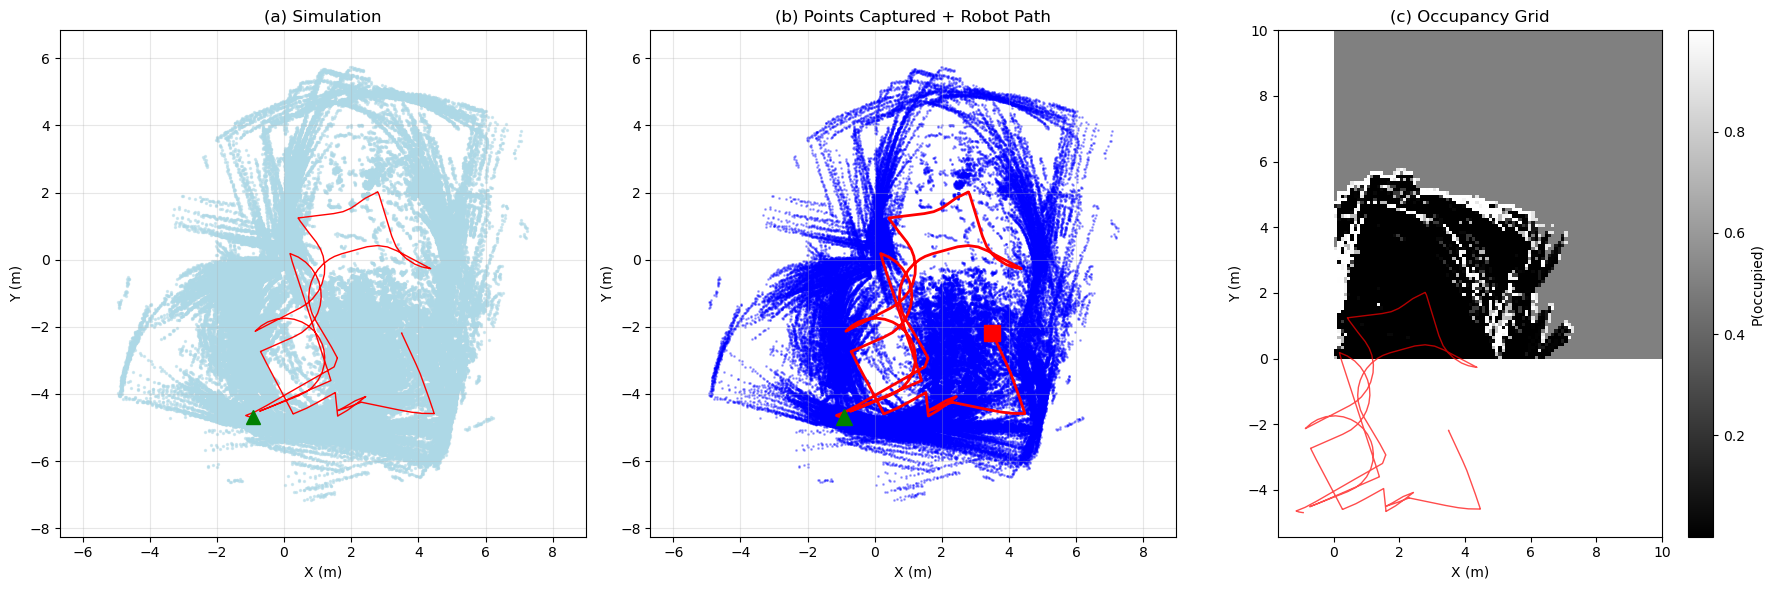

Combined visualization saved


In [11]:
# Create combined figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# (a) Simulation scene representation
ax1.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='lightblue', s=2, alpha=0.5)
ax1.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1)
ax1.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=10)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('(a) Simulation')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# (b) All laser points + trajectory (incremental plot)
ax2.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='blue', s=1, alpha=0.3)
ax2.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=2)
ax2.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=12)
ax2.plot(trajectory_array[-1, 0], trajectory_array[-1, 1], 'rs', markersize=12)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('(b) Points Captured + Robot Path')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# (c) Occupancy grid
prob_map = mapper.get_probability_map()
im = ax3.imshow(prob_map, cmap='gray', origin='lower',
               extent=[0, MAP_SIZE[0], 0, MAP_SIZE[1]])
ax3.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1, alpha=0.7)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title('(c) Occupancy Grid')
plt.colorbar(im, ax=ax3, label='P(occupied)')

plt.tight_layout()
plt.savefig(f"combined_result_{SCENE_TYPE}_cell{CELL_SIZE}.png", dpi=150)
plt.show()

print(f"Combined visualization saved")

In [12]:
# Debug: Check robot trajectory coordinates
if len(robot_trajectory) > 0:
    traj_arr = np.array(robot_trajectory)
    print("="*60)
    print("ROBOT TRAJECTORY ANALYSIS")
    print("="*60)
    print(f"Number of trajectory points: {len(robot_trajectory)}")
    print(f"\nX coordinate range: [{traj_arr[:, 0].min():.3f}, {traj_arr[:, 0].max():.3f}] m")
    print(f"Y coordinate range: [{traj_arr[:, 1].min():.3f}, {traj_arr[:, 1].max():.3f}] m")
    print(f"Theta range: [{np.rad2deg(traj_arr[:, 2].min()):.1f}, {np.rad2deg(traj_arr[:, 2].max()):.1f}] deg")
    print(f"\nGrid bounds: [{mapper.origin[0]:.1f}, {mapper.origin[0]+MAP_SIZE[0]:.1f}] x [{mapper.origin[1]:.1f}, {mapper.origin[1]+MAP_SIZE[1]:.1f}]")
    print(f"Grid origin: {mapper.origin}")

    # Check if robot was within grid bounds
    in_bounds_x = (traj_arr[:, 0] >= mapper.origin[0]) & (traj_arr[:, 0] <= mapper.origin[0] + MAP_SIZE[0])
    in_bounds_y = (traj_arr[:, 1] >= mapper.origin[1]) & (traj_arr[:, 1] <= mapper.origin[1] + MAP_SIZE[1])
    in_bounds = in_bounds_x & in_bounds_y

    print(f"\nPoints within grid bounds: {in_bounds.sum()} / {len(robot_trajectory)} ({100*in_bounds.sum()/len(robot_trajectory):.1f}%)")

    if in_bounds.sum() < len(robot_trajectory) * 0.8:
        print(f"\n[WARNING] Only {100*in_bounds.sum()/len(robot_trajectory):.1f}% of trajectory is within grid!")
        print("  Consider adjusting grid origin or size to better cover robot movement.")
else:
    print("No trajectory data available")

ROBOT TRAJECTORY ANALYSIS
Number of trajectory points: 245

X coordinate range: [-1.141, 4.469] m
Y coordinate range: [-4.692, 2.016] m
Theta range: [-179.3, 178.8] deg

Grid bounds: [0.0, 10.0] x [0.0, 10.0]
Grid origin: [0. 0.]

Points within grid bounds: 51 / 245 (20.8%)

[WARNING] Only 20.8% of trajectory is within grid!
  Consider adjusting grid origin or size to better cover robot movement.
